In [1]:
import pandas as pd 
import numpy as np 
import gc 
import lightgbm as lgb

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

load basic features 

In [3]:
%%time 
df_train = pd.read_pickle('../input/feats/df_trn_feat0.pkl')
# df_test = pd.read_pickle('../input/feats/df_test_feat0.pkl')

Wall time: 120 ms


In [4]:
df_train.columns

Index(['uidx', 'iidx', 'iid', 'region_city_label', 'tit_len', 'desc_len',
       'activation_date', 'month', 'day', 'weekday', 'param_1', 'param_2',
       'param_3', 'user_type', 'parent_category_name', 'price',
       'category_name', 'image_top_1', 'ads_cnt_by_uid', 'ads_cnt_by_iid',
       'deal_probability'],
      dtype='object')

load text features

In [5]:
%%time 
with pd.HDFStore('../input/feats/txt_td_tfidf_hash5.h5') as store:
    print(store.keys())
    df_trn_text_feat  = store['df_trn_text_feat']
    df_test_text_feat = store['df_test_text_feat']

['/df_test_text_feat', '/df_trn_text_feat']
Wall time: 162 ms


load fm features 

In [12]:
# %%time 
# with pd.HDFStore('../input/feats/fm_uidx_rc_cnt_lat2.h5') as store:
#     print(store.keys())
#     df_fm_uidx_rc_cnt_lat2 = store['fm_uidx_rc_cnt_lat2']

['/fm_uidx_rc_cnt_lat2']
Wall time: 42 ms


In [16]:
# df_fm_uidx_rc_cnt_lat2.head().T

,0,1,2,3,4
uidx,0.000000,1.000000,2.000000,3.000000,4.000000
region_city_label,449.000000,279.000000,376.000000,276.000000,518.000000
cnt,1.000000,1.000000,2.000000,1.000000,1.000000
uidx_fm_factor_0,0.002701,0.000503,0.017951,-0.015764,-0.009267
uidx_fm_factor_1,-0.002083,-0.000264,-0.012941,0.012905,-0.006171
region_city2_label_fm_factor_0,0.674149,-0.603294,1.224959,-0.586777,-0.696928
region_city2_label_fm_factor_1,-0.553216,0.641692,-0.736749,0.456205,-0.583239
uidx_fm_bias,-0.003021,-0.006119,-0.007854,-0.012045,-0.006555
region_city2_label_fm_bias,0.096357,0.117088,0.368274,0.032786,0.131809


In [18]:
# df_train = df_train.merge(df_fm_uidx_rc_cnt_lat2,how='left',on=['uidx','region_city_label'])
# df_test = df_test.merge(df_fm_uidx_rc_cnt_lat2,how='left',on=['uidx','region_city_label'])

NameError: name 'df_test' is not defined

In [24]:
# df_train['cnt_by_uidx_rc'] = df_train['cnt'].astype('float16')
# df_train.drop('cnt',axis=1,inplace=True)

combine features

In [6]:
%%time
df_train = pd.concat([df_train, df_trn_text_feat ],axis=1)

Wall time: 318 ms


In [7]:
selcols = list(df_train.columns)
drop_cols = ['deal_probability','activation_date','iid']
selcols = [col for col in selcols if col not in drop_cols]
X_train = df_train[selcols].copy()
y_train = df_train['deal_probability']

In [8]:
print('shape of X_train:',X_train.shape)

shape of X_train: (1503424, 38)


##### KFold

use built-in `lgb.cv`

In [9]:
df_train.columns

Index(['uidx', 'iidx', 'iid', 'region_city_label', 'tit_len', 'desc_len',
       'activation_date', 'month', 'day', 'weekday', 'param_1', 'param_2',
       'param_3', 'user_type', 'parent_category_name', 'price',
       'category_name', 'image_top_1', 'ads_cnt_by_uid', 'ads_cnt_by_iid',
       'deal_probability', 'title_tfidf_0', 'title_tfidf_1', 'title_tfidf_2',
       'title_tfidf_3', 'title_tfidf_4', 'title_hash_0', 'title_hash_1',
       'title_hash_2', 'title_hash_3', 'title_hash_4', 'desc_tfidf_0',
       'desc_tfidf_1', 'desc_tfidf_2', 'desc_tfidf_3', 'desc_tfidf_4',
       'desc_hash_0', 'desc_hash_1', 'desc_hash_2', 'desc_hash_3',
       'desc_hash_4'],
      dtype='object')

In [10]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',    
    'max_depth': -1,
    'num_leaves': 33,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.05,
    'verbose': 20
}  

predictors = list(X_train.columns)


categorical = ['month','day','weekday',
               'param_1','param_2','param_3',
               'category_name','parent_category_name',
               'user_type']

dtrain = lgb.Dataset(X_train, label=y_train, feature_name=predictors, categorical_feature=categorical)
cv_results = lgb.cv(lgbm_params, dtrain, 
                    num_boost_round=10000, 
                    nfold=4,
                    stratified=False,
                    early_stopping_rounds=10,
                    verbose_eval= 100)
print('done')

C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	cv_agg's rmse: 0.228366 + 0.00023069
[200]	cv_agg's rmse: 0.22672 + 0.000249414
[300]	cv_agg's rmse: 0.226041 + 0.000229927
[400]	cv_agg's rmse: 0.225654 + 0.00023063
[500]	cv_agg's rmse: 0.225341 + 0.000252254
[600]	cv_agg's rmse: 0.225125 + 0.000250674
[700]	cv_agg's rmse: 0.224968 + 0.000264488
[800]	cv_agg's rmse: 0.224826 + 0.00027525
[900]	cv_agg's rmse: 0.224706 + 0.00028873
[1000]	cv_agg's rmse: 0.224594 + 0.000296666
[1100]	cv_agg's rmse: 0.224504 + 0.000300117
[1200]	cv_agg's rmse: 0.224425 + 0.000295224
[1300]	cv_agg's rmse: 0.224349 + 0.000297056
[1400]	cv_agg's rmse: 0.224274 + 0.000292713
[1500]	cv_agg's rmse: 0.224216 + 0.000286755
[1600]	cv_agg's rmse: 0.22417 + 0.000289644
[1700]	cv_agg's rmse: 0.224123 + 0.000285902
[1800]	cv_agg's rmse: 0.224085 + 0.000291632
[1900]	cv_agg's rmse: 0.224046 + 0.000287158
[2000]	cv_agg's rmse: 0.224014 + 0.000286567
[2100]	cv_agg's rmse: 0.223987 + 0.00029178
[2200]	cv_agg's rmse: 0.223961 + 0.000290603
[2300]	cv_agg's rmse: 0.22

____

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [71]:
NFOLDS = 3
kf = KFold(n_splits=NFOLDS,random_state=0)
rmse_results = []
# def oof:
for nfold,(trn_idx, val_idx) in enumerate(kf.split(X_train)):
    x_trn, y_trn = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
    x_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = lgb.Dataset(x_trn,y_trn, feature_name=predictors, categorical_feature=categorical)
    dval   = lgb.Dataset(x_val,y_val, feature_name=predictors, categorical_feature=categorical)
    
    lgb_clf = lgb.train(lgbm_params,num_boost_round = 10000,
                        train_set = dtrain,
                        valid_sets = [dtrain, dval] ,                        
                        early_stopping_rounds=10,
                        verbose_eval= 100)                    
    y_pred = lgb_clf.predict(x_val)
    rmse = (mean_squared_error(y_pred,y_val))**0.5
    print('fold:{},\trmse:\t{:.4f}'.format(nfold,rmse))
    rmse_results.append(rmse)
    

C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 10 rounds.
[100]	training's rmse: 0.2281	valid_1's rmse: 0.22846
[200]	training's rmse: 0.2257	valid_1's rmse: 0.226915
[300]	training's rmse: 0.224365	valid_1's rmse: 0.226312
[400]	training's rmse: 0.22338	valid_1's rmse: 0.22598
[500]	training's rmse: 0.222548	valid_1's rmse: 0.22578
[600]	training's rmse: 0.221799	valid_1's rmse: 0.225605
[700]	training's rmse: 0.221099	valid_1's rmse: 0.225451
[800]	training's rmse: 0.220431	valid_1's rmse: 0.225333
[900]	training's rmse: 0.219799	valid_1's rmse: 0.22524
[1000]	training's rmse: 0.219156	valid_1's rmse: 0.225156
[1100]	training's rmse: 0.218557	valid_1's rmse: 0.2251
Early stopping, best iteration is:
[1157]	training's rmse: 0.218207	valid_1's rmse: 0.225046
fold:0,	rmse:	0.2250
Training until validation scores don't improve for 10 rounds.
[100]	training's rmse: 0.228017	valid_1's rmse: 0.228542
[200]	training's rmse: 0.225602	valid_1's rmse: 0.227084
[300]	training's rmse: 0.22428

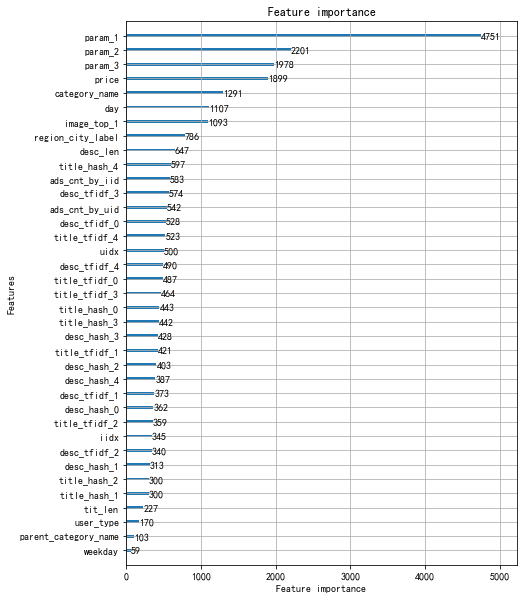

In [82]:
# feat_names = lgb_clf.feature_name()
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf,max_num_features=50, ax=ax)
# pd.DataFrame({'feat_idx':range(len(feat_names))})

____